# All-Sky Plot Utilities

This notebook provides a user's guide to functions in `desiutil.plots` for producing all-sky plots. Refer to the docstring for each function for details on its parameters and usage. These functions all require that the `basemap` package is installed for map projections (available via conda), and operations involving healpix maps also require that the `healpy` package is installed (not available via conda, so use `pip` instead).

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from desiutil.plots import init_sky, plot_healpix_map, plot_grid_map, plot_sky_circles, plot_sky_binned, prepare_data

## All-Sky Projection

Use `init_sky` to prepare the default [ECK4](http://usersguidetotheuniverse.com/index.php/2011/03/03/whats-the-best-map-projection/) all-sky projection, which can then be used for other operations like any other basemap:

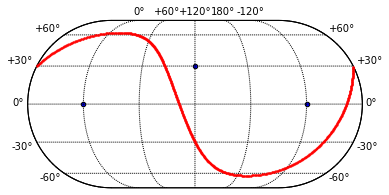

In [3]:
basemap = init_sky()
basemap.scatter([0, 120, 240], [0, 30, 0], latlon=True);

By default, the map is oriented so the DESI footprint does not wrap around in RA and shows the galactic plane in red, but you can change most of this with options:

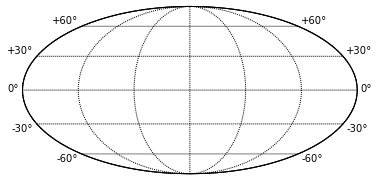

In [4]:
init_sky(projection='moll', ra_center=0, galactic_plane_color=None);

## Map Plotting

This section describes two methods that interpret an array of values as a map on the sphere and create a corresponding plot.  If you have a list of (RA, DEC) coordinates that you wish to plot, instead of a map, refer to the next section on catalog plotting.

Use `plot_grid_map()` to map a 2D array of values tabulated on a grid of RA and DEC values, with RA indexed by the first index.  In addition to the grid values, the grid edges must also be specified. Since values are associated with the cells between grid lines, a grid with dimensions [nRA, nDEC] has corresponding edge arrays of length nRA+1 and nDEC+1. The grid must wrap around the sphere in RA but does not need to cover the full range of DEC.  The grid can be chosen independently of the central RA of the map projection and any wrap-around grid column will be split automatically.

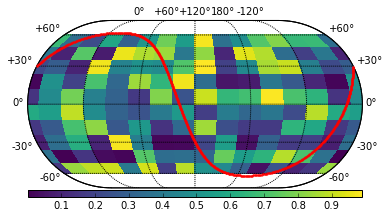

In [5]:
n_ra, n_dec = 15, 10
ra_edges = np.linspace(0., 360., n_ra + 1)
dec_edges = np.linspace(-60., 60., n_dec + 1)
data = np.random.uniform(size=(n_dec, n_ra))
plot_grid_map(data, ra_edges, dec_edges);

Use `plot_map_healpix()` to map a 1D array of values associated with a healpix map. The array size must exactly match the expected size for some value of the healpix `NSIDE` parameter.  Each pixel is rendered as a matplotlib polygon, so this function is somewhat slower than `plot_grid_map()` and also does not automatically wrap around pixels at the RA edges (which are not drawn at all, but this is less visible at larger values of `NSIDE`).

In [6]:
import healpy as hp

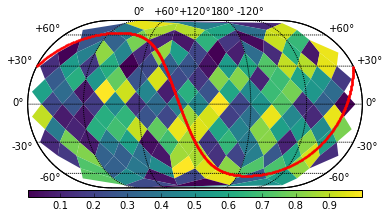

In [7]:
nside, nest = 4, False
data = np.random.uniform(size=hp.nside2npix(nside))
plot_healpix_map(data, nest);

Use the `colorbar` option to suppress the default colorbar, or the `label` option to add a colorbar label.

## Catalog Plotting

This section describes two methods for plotting a catalog of objects indexed by (RA, DEC).

Use `plot_sky_circles()` to draw a circular field of view centered on each (RA, DEC). This function is useful in DESI for displaying observing tiles and the default field of view is set accordingly.

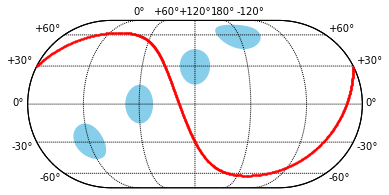

In [8]:
plot_sky_circles(ra_center=[0, 60, 120, 180], dec_center=[-30, 0, 30, 60],
                 field_of_view=30);

Note that the projection of a circular field of view is generally not circular. Face colors can be specified for each circle independently.

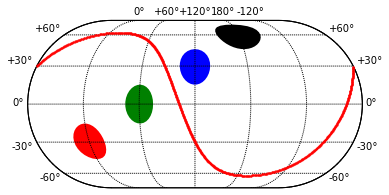

In [9]:
plot_sky_circles(ra_center=[0, 60, 120, 180], dec_center=[-30, 0, 30, 60],
                 field_of_view=30, facecolors=['r', 'g', 'b', 'k']);

Each (RA, DEC) can optionally be associated with some value that is used to determine the color of each circle.

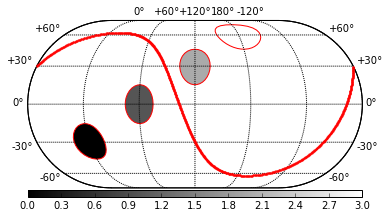

In [10]:
plot_sky_circles(ra_center=[0, 60, 120, 180], dec_center=[-30, 0, 30, 60],
                 field_of_view=30, data=[0, 1, 2, 3], cmap='gray', edgecolor='r');

Use `plot_sky_binned()` to automatically histogram object locations and display the resulting pixel counts per unit sky area as a map, using either the default `plot_grid_map()` or `plot_healpix_map()` (which requires that healpy is installed).

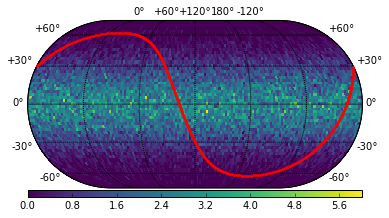

In [11]:
n = 50000
ra = 360 * np.random.uniform(size=n)
dec = np.clip(20 * np.random.normal(size=n), -90, +90)
plot_sky_binned(ra, dec);

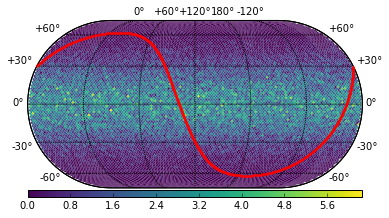

In [12]:
plot_sky_binned(ra, dec, plot_type='healpix');

The automatic histogramming is controlled by the value (in sq.deg.) of the `max_bin_area` parameter.  The default grid map is binned in cos(DEC) and RA and aims for roughly square pixels on the sky.  Use the `verbose` option to print details of the automatic histogramming. Note that a healpix map is more constrained so will generally result in smaller pixels for the same value of `max_bin_area` (and corrrespondingly larger shot noise).

Using 17 x 49 grid in cos(DEC) x RA with pixel area 49.523 sq.deg.


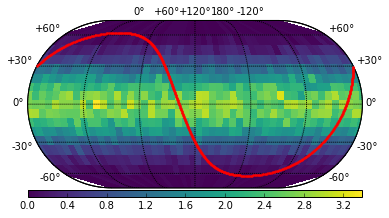

In [13]:
plot_sky_binned(ra, dec, max_bin_area=50, verbose=True);

Using healpix map with NSIDE=16 and pixel area 13.429 sq.deg.


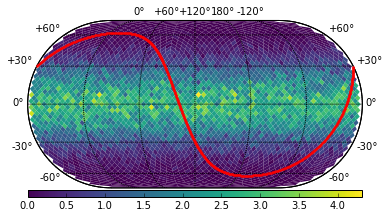

In [14]:
plot_sky_binned(ra, dec, plot_type='healpix', max_bin_area=50, verbose=True);

Instead of plotting object densities, you can provide an array of data associated with each object and the resulting map will display the mean data value per pixel. Note that empty bins, where the mean data is undefined, are automatically masked.

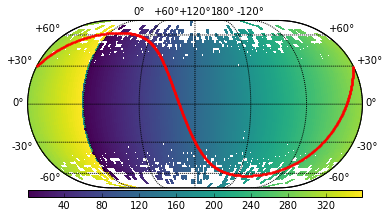

In [15]:
plot_sky_binned(ra, dec, data=ra);

## Data Preprocessing

These plotting routines all pass the data to be displayed through `prepare_data()` in order to provide a uniform API for how plot values are masked and mapped to display colors.

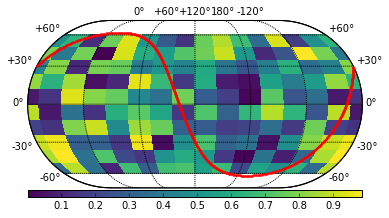

In [16]:
n_ra, n_dec = 15, 10
ra_edges = np.linspace(0., 360., n_ra + 1)
dec_edges = np.linspace(-60., 60., n_dec + 1)
data = np.random.uniform(size=(n_dec, n_ra))
plot_grid_map(data, ra_edges, dec_edges);

For more control, you can call `prepare_data()` yourself before calling the map functions.  For example, you can explicitly mask some pixels in a map:

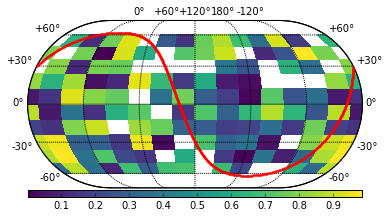

In [17]:
data2 = prepare_data(data, mask=(0.4 < data) & (data < 0.6))
plot_grid_map(data2, ra_edges, dec_edges);

You can also specify the clipping to apply at both ends (lo/hi) using a mixture of percentiles or absolute values.

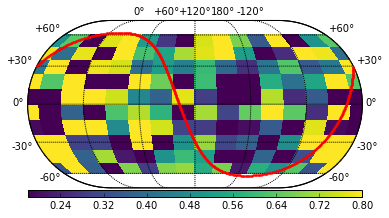

In [18]:
data2 = prepare_data(data, clip_lo='20%', clip_hi=0.8)
plot_grid_map(data2, ra_edges, dec_edges);

Values outside the clip range are normally displayed (after clipping) but can instead be masked by adding '!' to the clip specification. Note that quotes are optional for numeric clip values (0.8) but required when using '%' or '!'.

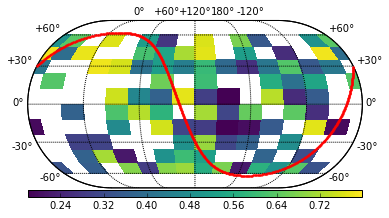

In [19]:
data2 = prepare_data(data, clip_lo='!20%', clip_hi='!0.8')
plot_grid_map(data2, ra_edges, dec_edges);

If the range of clipped data is smaller than the clip limits, the tighter limits will be used for the color scale by default:

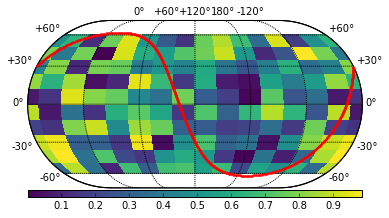

In [20]:
data2 = prepare_data(data, clip_lo=-0.5, clip_hi=1.5)
plot_grid_map(data2, ra_edges, dec_edges);

However, you can force the color scale to use either clip limit by passing `save_limits=True`. This is useful when making a series of plots with a consistent colorscale.

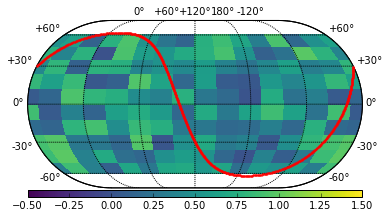

In [21]:
data2 = prepare_data(data, clip_lo=-0.5, clip_hi=1.5, save_limits=True)
plot_grid_map(data2, ra_edges, dec_edges);

The same techniques can be used with the data passed to `plot_sky_circles()`.

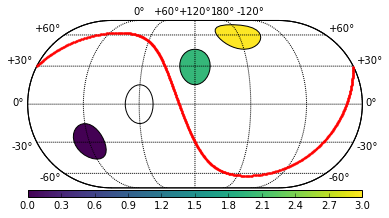

In [22]:
data = prepare_data([0, 1, 2, 3], mask=[False, True, False, False])
plot_sky_circles(ra_center=[0, 60, 120, 180], dec_center=[-30, 0, 30, 60],
                 field_of_view=30, data=data, edgecolor='k');

The `plot_sky_binned()` function calculates the data to plot internally, but has parameters `clip_lo` and `clip_hi` that are used to prepare this data.

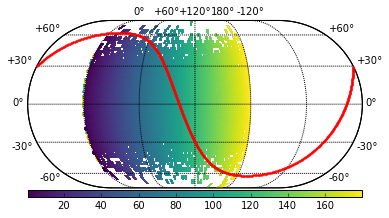

In [23]:
plot_sky_binned(ra, dec, data=ra, clip_hi='!180');